In [9]:
import math
vetor_a = [1, 1, 3]
vetor_b = [
    0.5 * (vetor_a[0] - vetor_a[1] - vetor_a[2]),
    0.5 * (vetor_a[1] - vetor_a[2] - vetor_a[0]),
    0.5 * (vetor_a[2] - vetor_a[0] - vetor_a[1]),
]
c = math.sqrt(
    vetor_b[0] * vetor_b[1] + vetor_b[1] * vetor_b[2] + vetor_b[2] * vetor_b[0]
)

f_inv = 10800
vetor_h = [-1, 0, 0]
vetor_f = [0.1, 0, 0]
g_0 = 8
kappa_0 = 1 / 48
nu_0 = kappa_0

In [10]:
import numpy as np
import matplotlib.pyplot as plt


def pe_model(x, y, z):
    dx = np.zeros(3)
    dy = np.zeros(3)
    dz = np.zeros(3)

    for i in range(3):
        j = (i + 1) % 3
        k = (i + 2) % 3

        dx[i] = (
            vetor_a[i] * vetor_b[i] * x[j] * x[k]
            - c * (vetor_a[i] - vetor_a[k]) * x[j] * y[k]
            + c * (vetor_a[i] - vetor_a[k]) * x[j] * y[k]
            - c * (vetor_a[i] - vetor_a[j]) * y[j] * x[k]
            - 2 * c**2 * y[i] * y[k]
            - nu_0 * vetor_a[i] ** 2 * x[i]
            + vetor_a[i] * y[i]
            - vetor_a[i] * z[i]
        )

        dy[i] = (
            -vetor_a[k] * vetor_b[k] * x[j] * y[k]
            - vetor_a[j] * vetor_b[j] * y[j] * x[k]
            + c * (vetor_a[k] - vetor_a[j]) * y[j] * y[k]
            - vetor_a[i] * x[i]
            - nu_0 * vetor_a[i] ** 2 * y[i]
        )

        dz[i] = (
            -vetor_b[k] * x[j] * (z[k] - vetor_h[k])
            - vetor_b[j] * (z[j] - vetor_h[j]) * x[k]
            + c * y[j] * (z[k] - vetor_h[k])
            - c * (z[j] - vetor_h[j]) * y[k]
            + g_0 * vetor_a[i] * x[i]
            - kappa_0 * vetor_a[i] * z[i]
            + vetor_f[i]
        )

    return dx, dy, dz

def runge_kutta_pe(x_inicial, y_inicial, z_inicial, dias):
    t_final = dias * 8
    dt_tau = 1 / 24
    n_steps = int(t_final / dt_tau)

    t = np.linspace(0, t_final, n_steps)
    x = np.zeros((n_steps, 3))
    y = np.zeros((n_steps, 3))
    z = np.zeros((n_steps, 3))

    x[0] = x_inicial
    y[0] = y_inicial
    z[0] = z_inicial

    for i in range(1, n_steps):
        dx1, dy1, dz1 = pe_model(x[i - 1], y[i - 1], z[i - 1])
        k1x = dt_tau * dx1
        k1y = dt_tau * dy1
        k1z = dt_tau * dz1

        dx2, dy2, dz2 = pe_model(
            x[i - 1] + k1x / 2, y[i - 1] + k1y / 2, z[i - 1] + k1z / 2
        )
        k2x = dt_tau * dx2
        k2y = dt_tau * dy2
        k2z = dt_tau * dz2

        dx3, dy3, dz3 = pe_model(
            x[i - 1] + k2x / 2, y[i - 1] + k2y / 2, z[i - 1] + k2z / 2
        )
        k3x = dt_tau * dx3
        k3y = dt_tau * dy3
        k3z = dt_tau * dz3

        dx4, dy4, dz4 = pe_model(x[i - 1] + k3x, y[i - 1] + k3y, z[i - 1] + k3z)
        k4x = dt_tau * dx4
        k4y = dt_tau * dy4
        k4z = dt_tau * dz4

        x[i] = x[i - 1] + (k1x + 2 * k2x + 2 * k3x + k4x) / 6
        y[i] = y[i - 1] + (k1y + 2 * k2y + 2 * k3y + k4y) / 6
        z[i] = z[i - 1] + (k1z + 2 * k2z + 2 * k3z + k4z) / 6

    t_days = t / 8
    return t_days, x, y, z

In [11]:
def qg_model(y):
    dy = np.zeros(3)
    for i in range(3):
        j = (i + 1) % 3
        k = (i + 2) % 3
        dy[i] = (
            g_0 * c * (vetor_a[k] - vetor_a[j]) * y[j] * y[k]
            - vetor_a[i] * (vetor_a[i] * g_0 * nu_0 + kappa_0) * y[i]
            - c * vetor_h[k] * y[j]
            + c * vetor_h[j] * y[k]
            + vetor_f[i]
        ) / (vetor_a[i] * g_0 + 1)
    return dy

def runge_kutta_qg(y0, t, dias_total):
    n = dias_total
    y = np.zeros((n, len(y0)))
    y[0] = y0
    dt = 1  

    for i in range(n - 1):
        k1 = qg_model(y[i])
        k2 = qg_model(y[i] + k1 * dt / 2)
        k3 = qg_model(y[i] + k2 * dt / 2)
        k4 = qg_model(y[i] + k3 * dt)
        y[i + 1] = y[i] + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

    return t, y

In [12]:
def plot2d(t, x, y, z, dias):
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(t, x[:, 0], "-", linewidth=1.5, label="x1", color="green")
    ax.plot(t, y[:, 0], "-", linewidth=1.5, label="y1", color="blue")
    ax.plot(t, z[:, 0], "-", linewidth=1.5, label="z1", color="red")

    ax.set_xlim(0, dias)
    ax.set_ylim(-0.4, 0.6)
    ax.set_xlabel("Dias")
    ax.grid(True)
    ax.legend()

    return fig, ax

def plot_y2y3(y):
    plt.figure(figsize=(12, 4))  
    plt.plot(y[:, 2], y[:, 1], "r-", linewidth=1.5)  
    plt.xlabel("y3")
    plt.ylabel("y2")
    plt.grid(True, linestyle="--", alpha=0.3)  
    plt.title("Atrator L80")

    plt.xlim(-0.3, 0.3)
    plt.ylim(-0.5, 0.5)



def plot_y1y3(y):
    plt.figure(figsize=(12, 4))  
    plt.plot(y[:, 0], y[:, 2], "r-", linewidth=1.5)  
    plt.xlabel("y1")
    plt.ylabel("y3")
    plt.grid(True, linestyle="--", alpha=0.3)  
    plt.title("Atrator L80")

    plt.xlim(-0.3, 0.6)
    plt.ylim(-0.3, 0.3)



def plot_y3y1(y):
    plt.figure(figsize=(12, 4))  
    plt.plot(y[:, 2], y[:, 0], "r-", linewidth=1.5)  
    plt.xlabel("y3")
    plt.ylabel("y1")
    plt.grid(True, linestyle="--", alpha=0.3)  
    plt.title("Atrator L80")

    plt.ylim(-0.25, 0.5)
    plt.xlim(-0.25, 0.25)



def plot_evolucao_y(t, y, dias):
    fig, ax = plt.subplots(figsize=(12, 8))

    ax.plot(t, y[:, 0], "-", linewidth=1.5, label="y1", color="green")
    ax.plot(t, y[:, 1], "-", linewidth=1.5, label="y2", color="blue")
    ax.plot(t, y[:, 2], "-", linewidth=1.5, label="y3", color="red")

    ax.set_xlim(0, dias)
    ax.set_ylim(-0.4, 0.6)
    ax.set_xlabel("Dias")
    ax.grid(True)
    ax.legend()

    return fig, ax


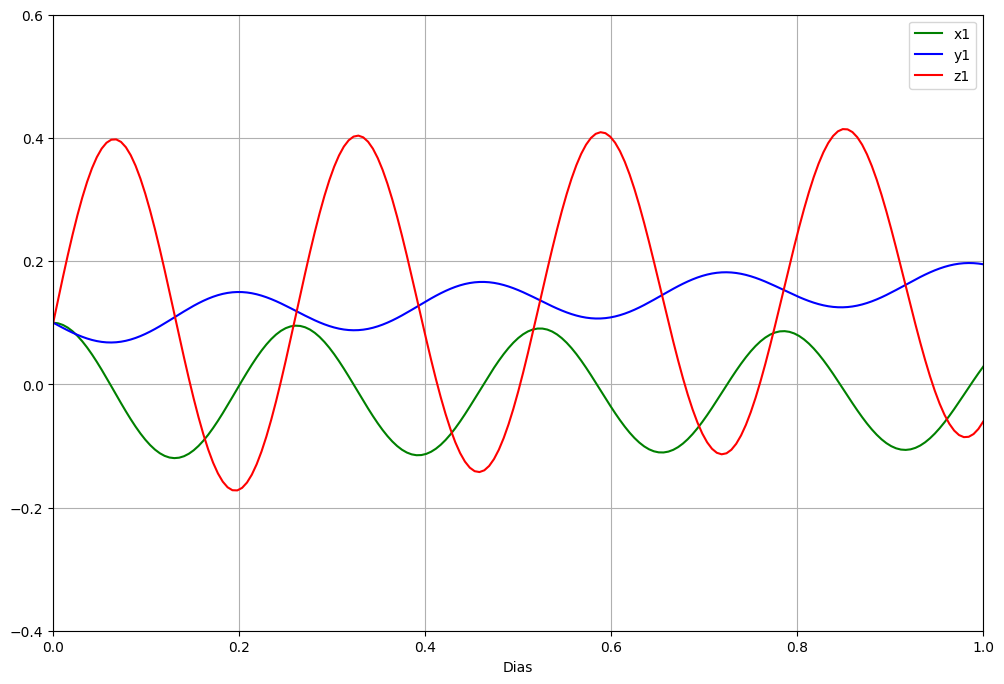

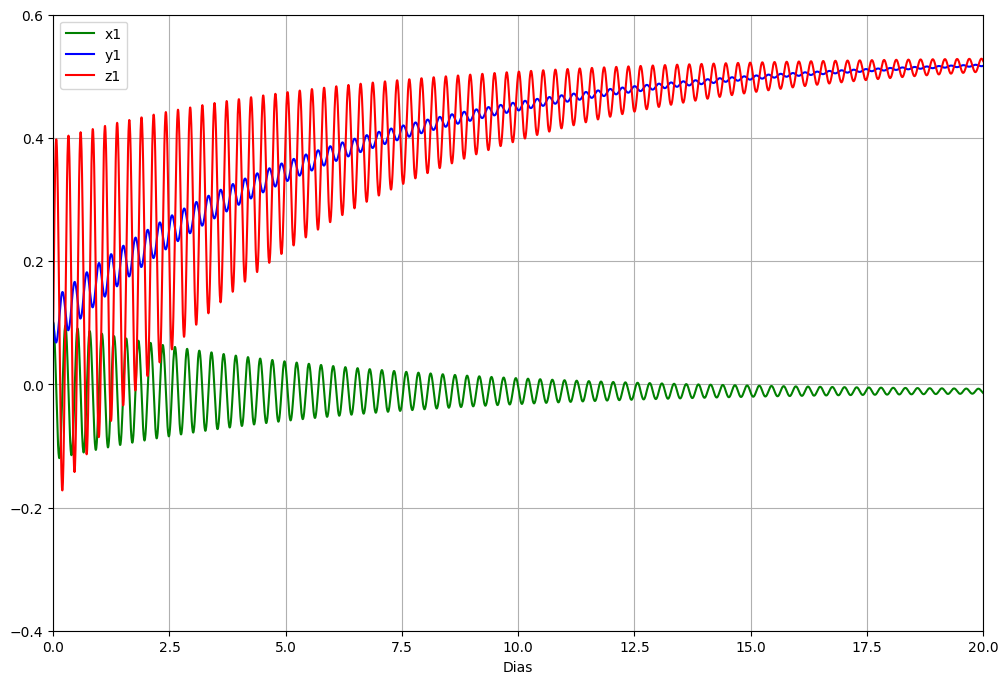

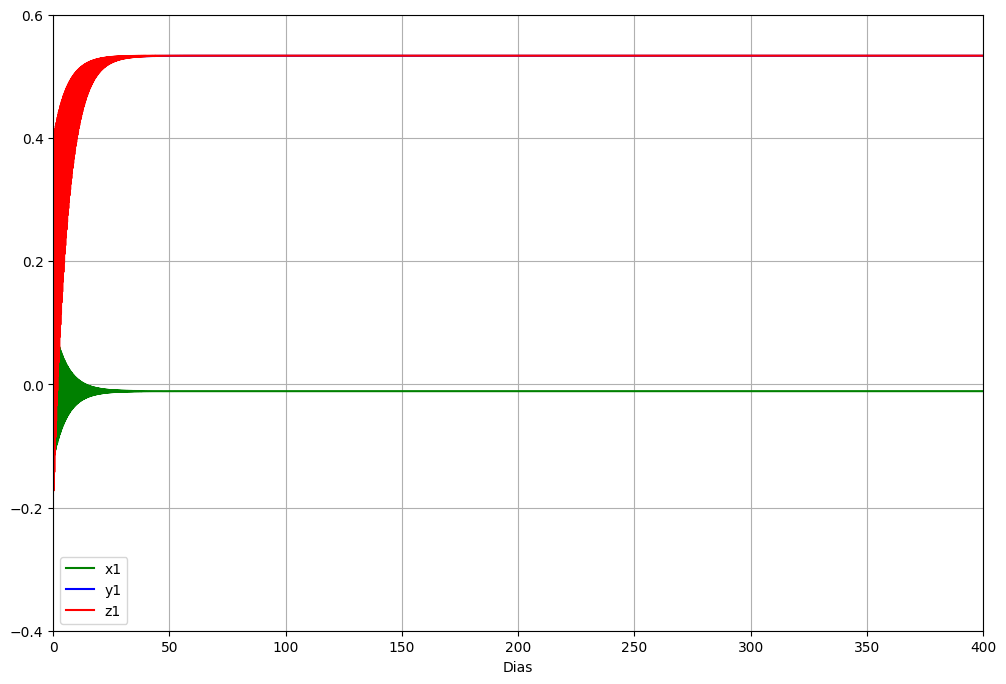

In [13]:
dias_total = 400

x0 = [0.1, 0, 0]
y0 = [0.1, 0, 0]
z0 = [0.1, 0, 0]

t_fig1, x_fig1, y_fig1, z_fig1 = runge_kutta_pe(x0, y0, z0, dias_total)

plot2d(t_fig1, x_fig1, y_fig1, z_fig1, 1);
plot2d(t_fig1, x_fig1, y_fig1, z_fig1, 20);
plot2d(t_fig1, x_fig1, y_fig1, z_fig1, dias_total);

plt.show()

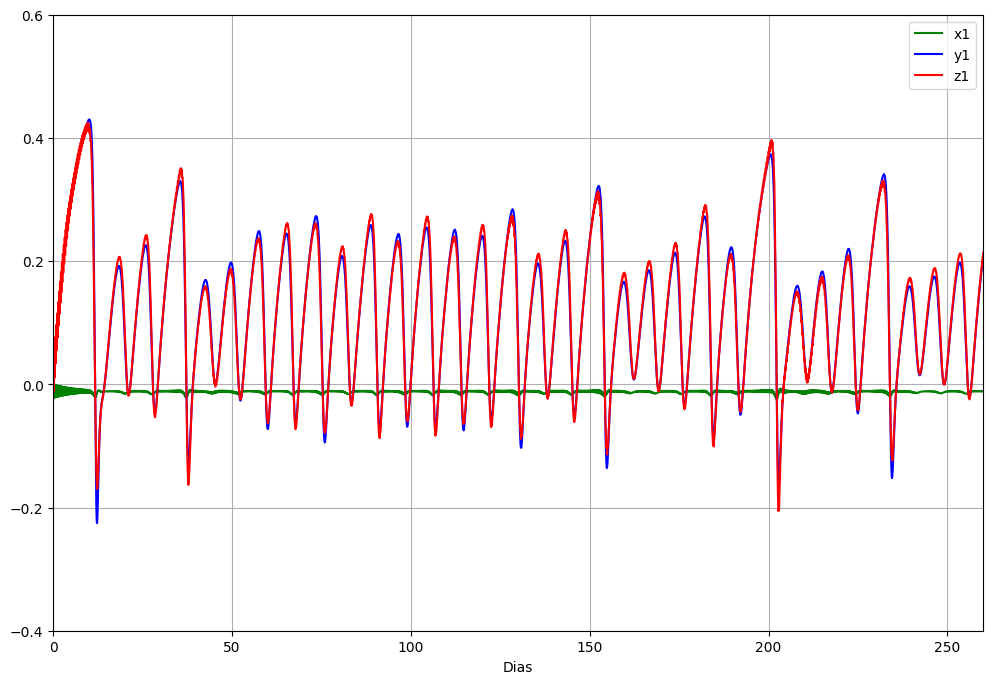

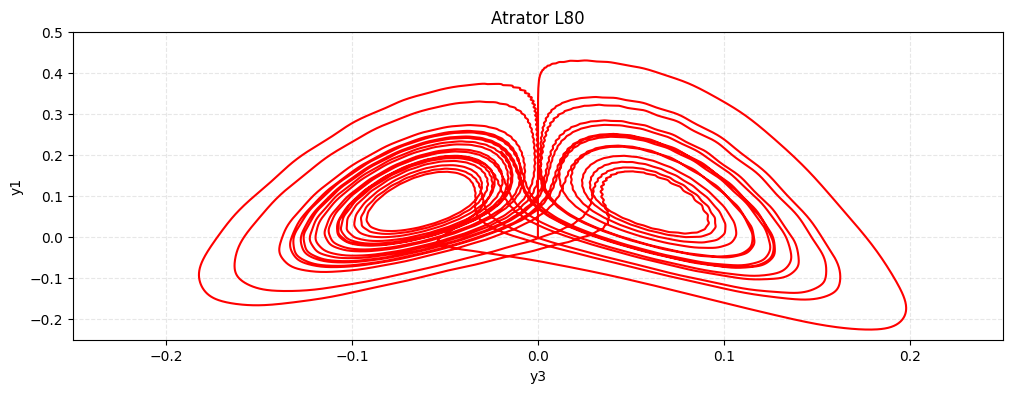

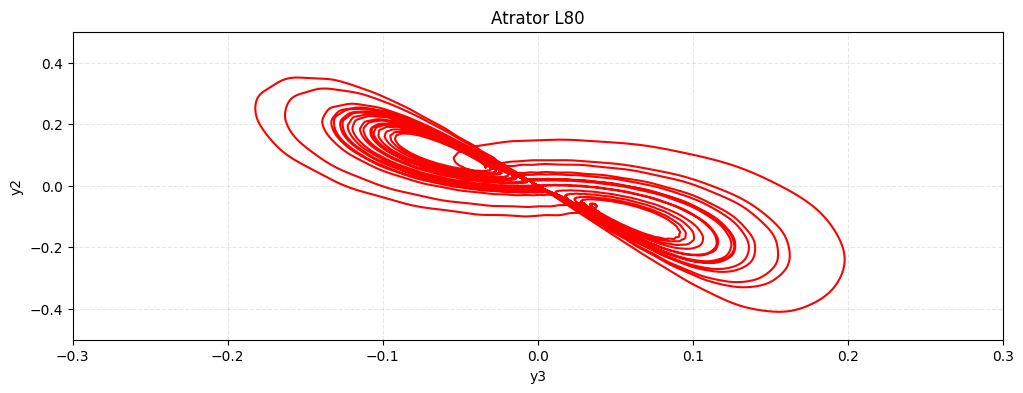

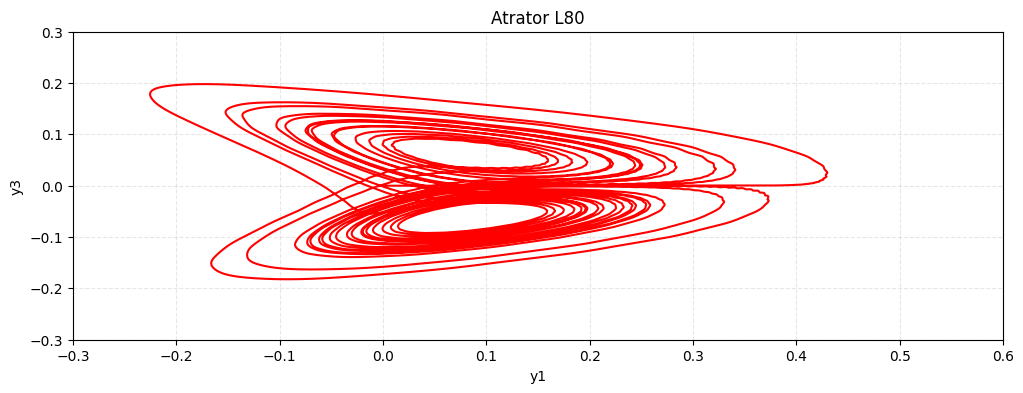

In [17]:
y1 = (
   vetor_f[1]
   / vetor_a[1]
   * nu_0
   * (1 + vetor_a[1] * g_0 + nu_0**2 * vetor_a[1] ** 2)
)
z1 = (1 + nu_0**2 * vetor_a[1] ** 2) * y1
x1 = -nu_0 * vetor_a[1] * y1

dias_hardley01 = 260

x_hardley01_inicial = [x1, 0, 0]
y_hardley01_inicial = [y1, -(10 ** (-5)), 0]
z_hardley01_inicial = [z1, 10 ** (-5), 0]

t_hardley01, x_hardley01, y_hardley01, z_hardley01 = runge_kutta_pe(
   x_hardley01_inicial, 
   y_hardley01_inicial, 
   z_hardley01_inicial, 
   dias_hardley01
)

plot2d(t_hardley01, x_hardley01, y_hardley01, z_hardley01, dias_hardley01);
plot_y3y1(y_hardley01);
plot_y2y3(y_hardley01);
plot_y1y3(y_hardley01);

plt.show()

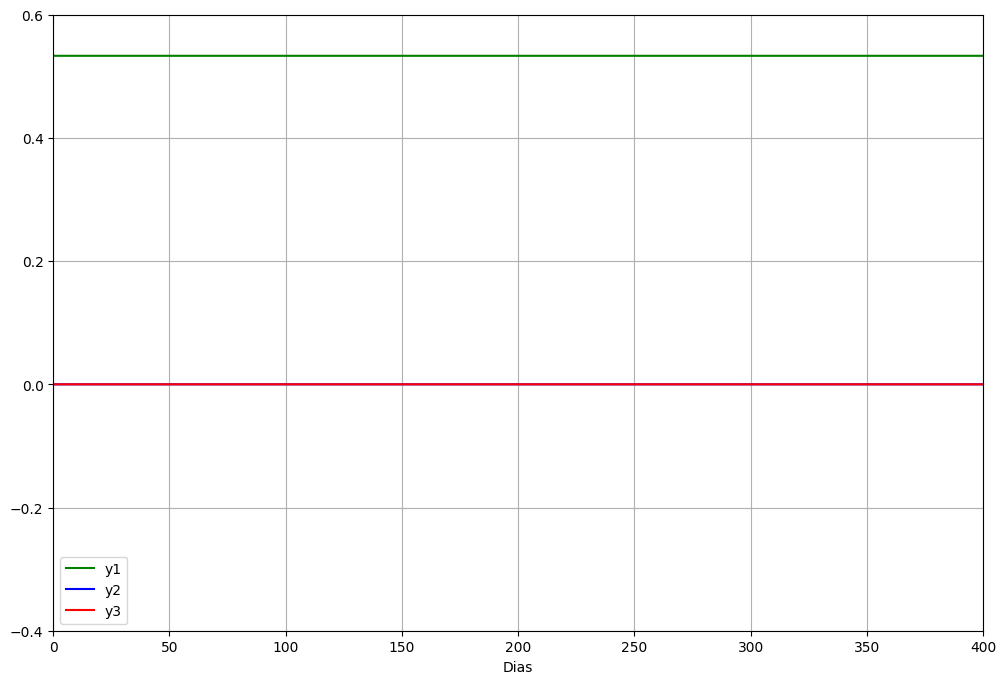

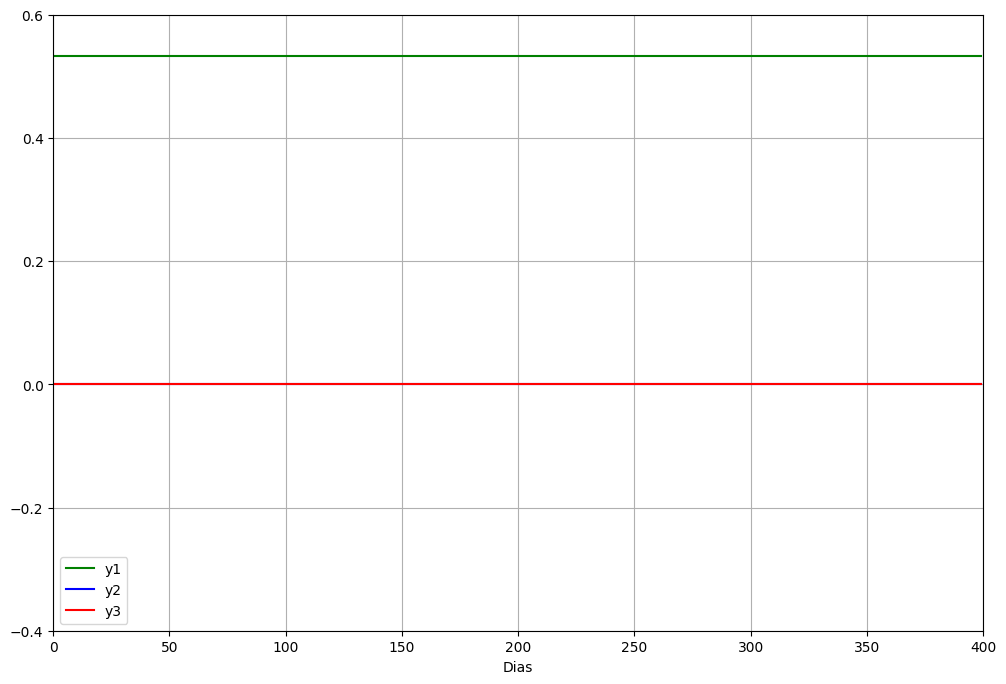

In [15]:
dias_total = 400

x_hardley02_inicial = [-0.01111, 0, 0]
y_hardley02_inicial = [0.53331, 0, 0]
z_hardle02_inicial = [0.53354, 0, 0]

t_hardley02, x_hardley02, y_hardley02, z_hardley02 = runge_kutta_pe(
   x_hardley02_inicial, 
   y_hardley02_inicial, 
   z_hardle02_inicial, 
   dias_total
)

plot_evolucao_y(t_hardley02, y_hardley02, dias_total);

y0 = [0.53333, 0, 0]
t = np.arange(0, dias_total)

t0, sol0 = runge_kutta_qg(y0, t, dias_total)

plot_evolucao_y(t0, sol0, dias_total);

plt.show()